# TP4.A Advanced Topics

## Part 1. GAN (Generative Adversarial Network)



The following code is from https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [5]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K

import random
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf

from keras.backend import set_session,tensorflow_backend

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

**Build the Generator**

In [2]:
noise_shape = (100,)
img_shape = (28,28,1)

model = Sequential()
model.add(Dense(256, input_shape=noise_shape))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(784, activation='tanh'))
model.add(Reshape(img_shape))

model.summary()

noise = Input(shape=noise_shape)
img = model(noise)

generator =  Model(inputs = noise, outputs = img)

optimizer = Adam(0.0002, 0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)             

**Build the Discriminator**

In [3]:
model = Sequential()

model.add(Flatten(input_shape=img_shape))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

img = Input(shape=img_shape)
validity = model(img)

discriminator =  Model(inputs = img, outputs = validity)
discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

**Combine Generator and Discriminator**

In [4]:
z = Input(shape=(100,))
img = generator(z)

# we will only train the generator when we run the combined model
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         1493520   
_________________________________________________________________
model_2 (Model)              (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


**Function to print out images**

In [5]:
def print_imgs():
    r, c = 2, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = (1/2.5) * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c, figsize=(20, 4))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

**Train the model.** Note: If you rerun the model, it will continue with the left off weights. To train from scratch, please recompile your model.

/home/matt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.628997, acc.: 77.34%] [G loss: 0.868429]


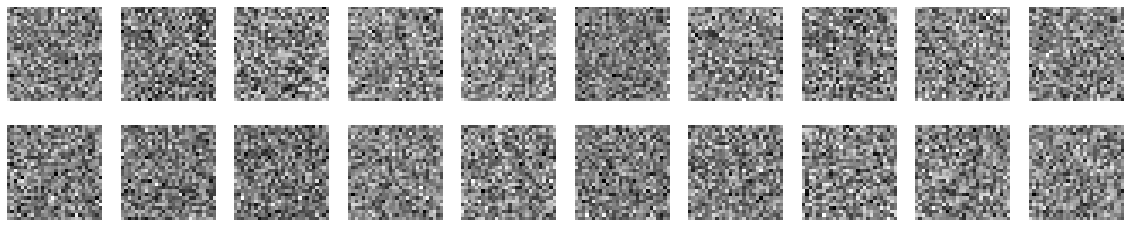

/home/matt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.609920, acc.: 65.62%] [G loss: 0.925371]


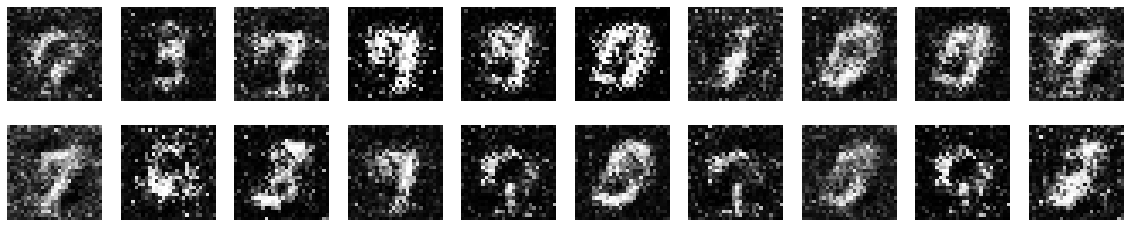

2000 [D loss: 0.567106, acc.: 71.88%] [G loss: 0.985187]


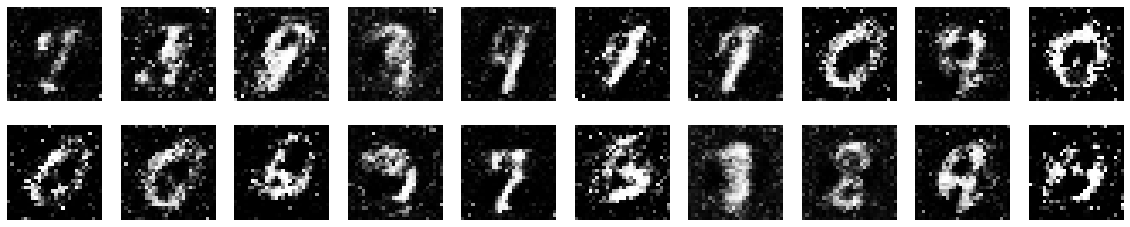

3000 [D loss: 0.618009, acc.: 66.41%] [G loss: 0.910134]


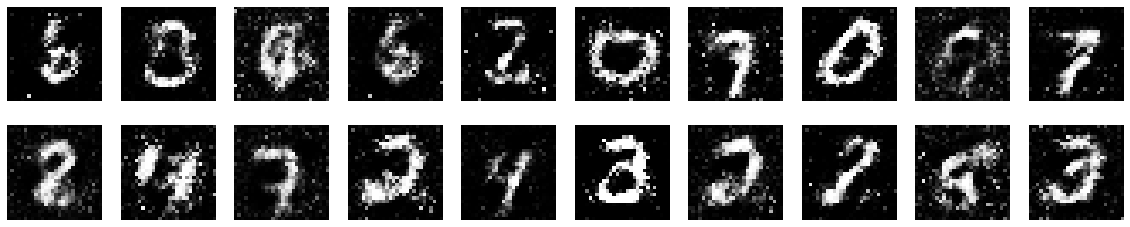

4000 [D loss: 0.676436, acc.: 61.72%] [G loss: 0.853340]


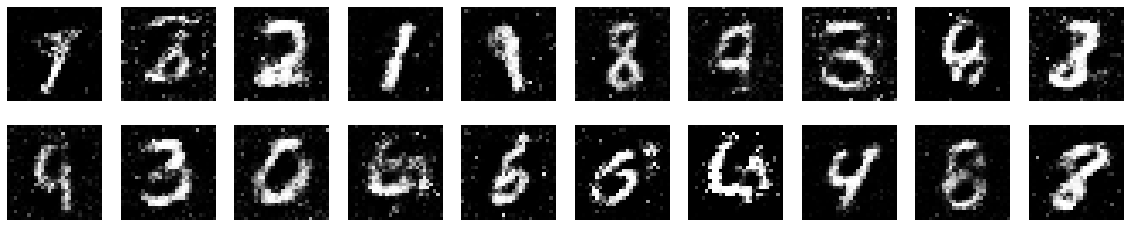

5000 [D loss: 0.637236, acc.: 61.72%] [G loss: 0.861762]


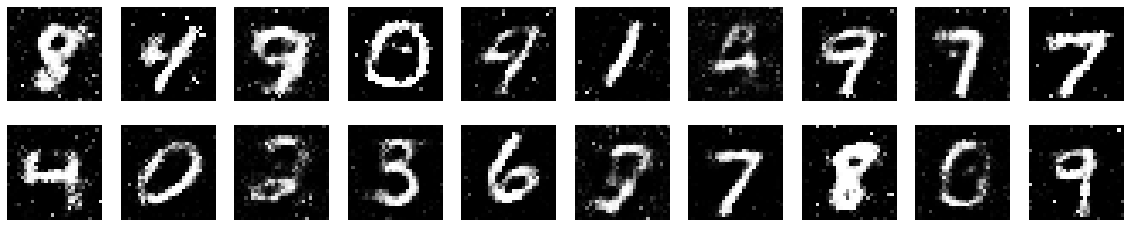

6000 [D loss: 0.669020, acc.: 60.94%] [G loss: 0.846184]


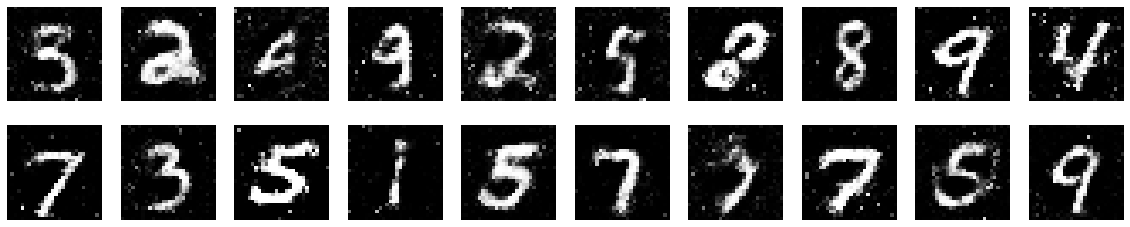

7000 [D loss: 0.686241, acc.: 53.91%] [G loss: 0.826003]


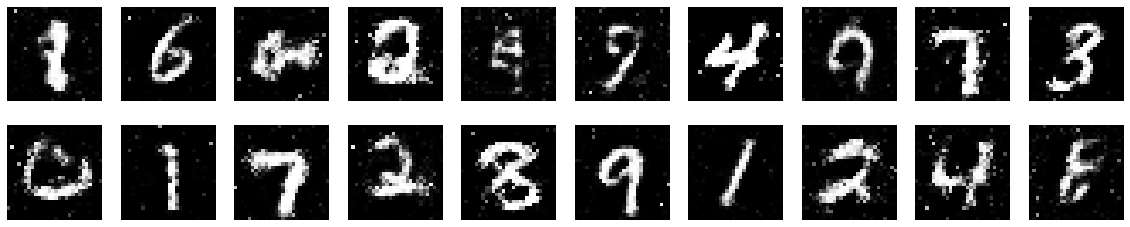

8000 [D loss: 0.659046, acc.: 61.72%] [G loss: 0.833465]


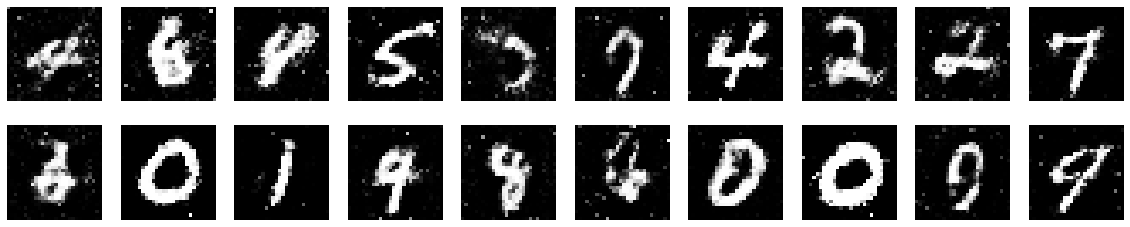

9000 [D loss: 0.735727, acc.: 46.09%] [G loss: 0.838924]


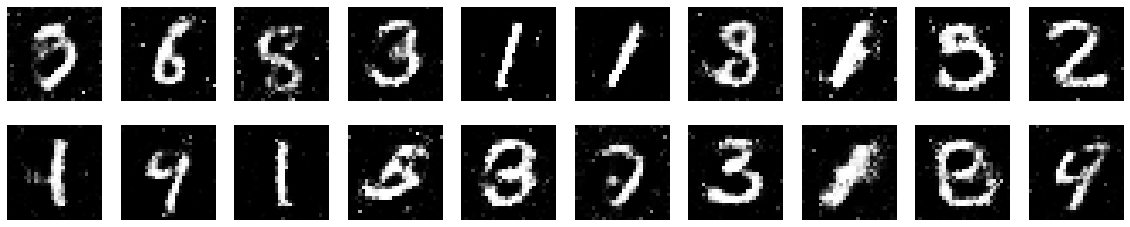

In [6]:
epochs = 10000
batch_size = 128
print_interval = 1000

# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

half_batch = int(batch_size / 2)

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)

    if epoch % print_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 
                                                               100*d_loss[1], g_loss))
        print_imgs()

### Exercise 1. GAN for CIFAR-10

Modify the code above to train on CIFAR-10.

In [6]:
import keras

from keras.models import Sequential

from keras.layers import Conv2D, Flatten, Dropout, Dense, UpSampling2D, Reshape
from keras.layers import Conv2DTranspose, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop

from keras.datasets import cifar10


import matplotlib.pylab as plt

from tqdm import tnrange
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [7]:
noise_shape = (110,)
img_shape = (32,32,3)

model = Sequential()
model.add(Dense(256, input_shape=noise_shape))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(3072, activation='tanh'))
model.add(Reshape([32,32,3]))

model.summary()

noise = Input(shape=noise_shape)
img = model(noise)

generator =  Model(inputs = noise, outputs = img)

optimizer = Adam(0.0002, 0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               28416     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
__________

In [8]:
model = Sequential()

model.add(Flatten(input_shape=img_shape))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

img = Input(shape=img_shape)
validity = model(img)

discriminator =  Model(inputs = img, outputs = validity)
discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
_________________________________________________________________


Build generator

In [9]:
z = Input(shape=(110,))
img = generator(z)

# we will only train the generator when we run the combined model
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 110)               0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         3841280   
_________________________________________________________________
model_2 (Model)              (None, 1)                 1704961   
Total params: 5,546,241
Trainable params: 3,837,696
Non-trainable params: 1,708,545
_________________________________________________________________


In [10]:
def print_imgs():
    r, c = 2, 10
    noise = np.random.normal(0, 1, (r * c, 110))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = (1/2.5) * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c, figsize=(20, 4))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

/home/emerick/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.761868, acc.: 26.56%] [G loss: 0.540003]


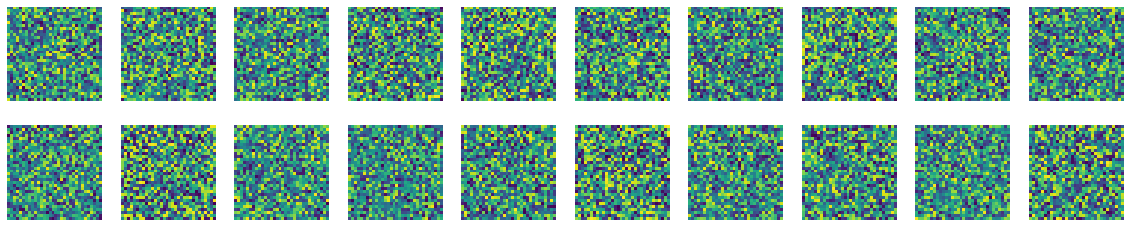

/home/emerick/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: 

In [11]:
from keras.datasets import cifar10

epochs = 20000
batch_size = 128
save_interval = 2000

# Load the dataset
(X_train, _), (_, _) = cifar10.load_data()


#Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5


half_batch = int(batch_size / 2)

#Create lists for logging the losses
d_loss_logs_r = []
d_loss_logs_f = []
g_loss_logs = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 110))

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 110))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)

    if epoch % save_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
               (epoch, d_loss[0], 100*d_loss[1], g_loss))
        print_imgs()

# Part 2. Autoencoder

## 2.1 Feed-forward Autoencoder 

We write a quick feed-forward autoencoder mapping from images of size 728 to 32, then decode back to size 728

In [12]:
input_img = Input(shape=(28,28,1,))
flat = Flatten()(input_img)
encoded = Dense(128, activation='relu')(flat)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
decoded = Reshape(target_shape = (28,28,1,))(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_20 (Dense)             (None, 128)               8320      
__________

In [13]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [14]:
def print_imgs(X):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 2))
    for i in range(n):
        # display reconstruction
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(X[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    plt.close()

**Train the Autoencoder**

original images:


<Figure size 1440x144 with 0 Axes>

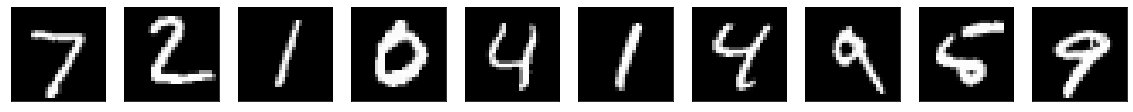

decoded images at epoch  5 :


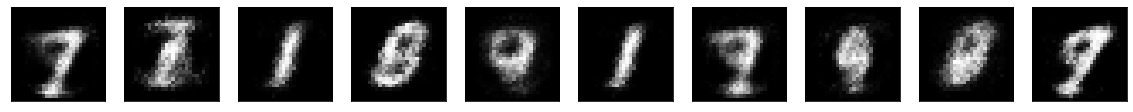

KeyboardInterrupt: 

In [15]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 2))
print('original images:')
print_imgs(x_test[:10])
    
for i in range(10):
    autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                verbose = 0)
    
    # encode and decode some digits
    # note that we take them from the *test* set
    print('decoded images at epoch ', i*5 + 5, ':')
    decoded_imgs = autoencoder.predict(x_test[:10])
    print_imgs(decoded_imgs)

### Super encoding
In this case we reduce the encoded dimension to 2. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_23 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 66        
_________________________________________________________________
dense_25 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_26 (Dense)             (None, 128)               4224      
__________

<Figure size 1440x144 with 0 Axes>

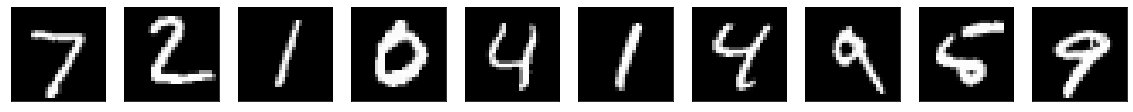

decoded images at epoch  5 :


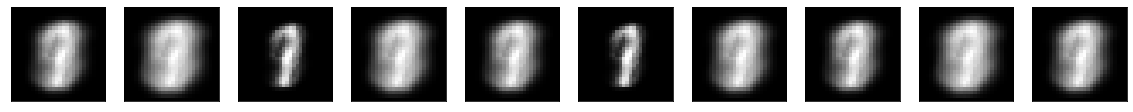

KeyboardInterrupt: 

In [16]:
input_img = Input(shape=(28,28,1,))
flat = Flatten()(input_img)
encoded = Dense(128, activation='relu')(flat)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(2, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
decoded = Reshape(target_shape = (28,28,1,))(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

n = 10  # how many digits we will display
plt.figure(figsize=(20, 2))
print('original images:')
print_imgs(x_test[:10])
    
for i in range(10):
    autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                verbose = 0)
    
    # encode and decode some digits
    # note that we take them from the *test* set
    print('decoded images at epoch ', i*5 + 5, ':')
    decoded_imgs = autoencoder.predict(x_test[:10])
    print_imgs(decoded_imgs)

## 2.2 Convolutional autoencoder

### Exercise.  
Write code for a convolutional autoencoder and see whether the performance is improved

In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(28, 28, 1))  

x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [18]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

original images:


<Figure size 1440x144 with 0 Axes>

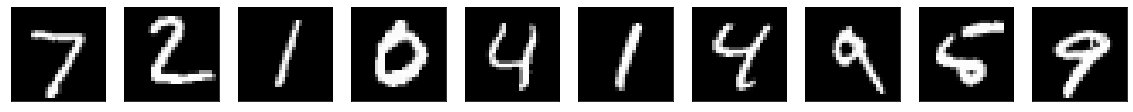

decoded images at epoch  2 :


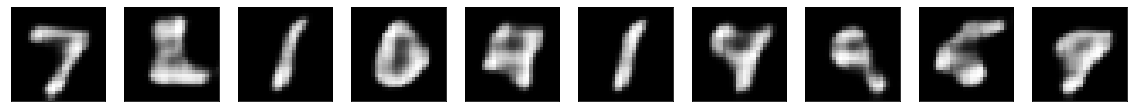

KeyboardInterrupt: 

In [19]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 2))
print('original images:')
print_imgs(x_test[:10])
    
for i in range(10):
    autoencoder.fit(x_train, x_train,
                epochs=2,
                batch_size=256,
                shuffle=True,
                verbose = 0)
    
    # encode and decode some digits
    # note that we take them from the *test* set
    print('decoded images at epoch ', i*2 + 2, ':')
    decoded_imgs = autoencoder.predict(x_test[:10])
    print_imgs(decoded_imgs)

## 2.3 Application to image denoising

We first create some noisy images

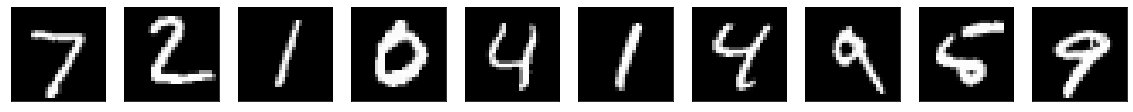

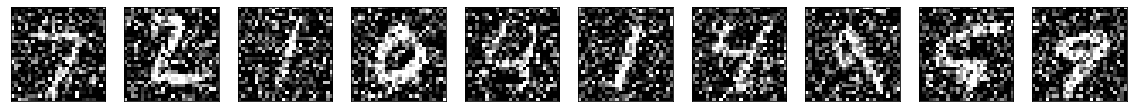

In [20]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print_imgs(x_test[:10])
print_imgs(x_test_noisy[:10])

And build a convolutional autoencoder

In [21]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [22]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Suppose that we have only 1000 available pairs of noisy-clean images to train.

<Figure size 1440x144 with 0 Axes>

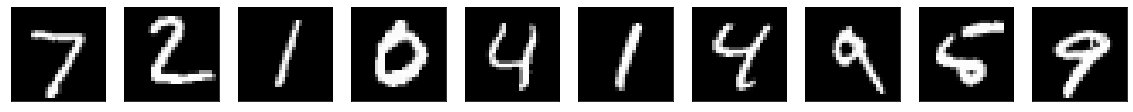

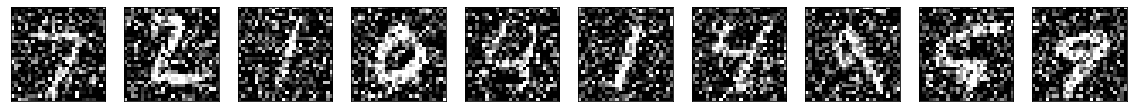

decoded images at epoch  50 :


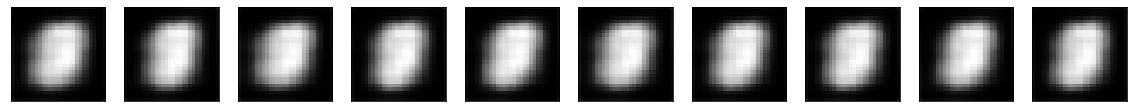

decoded images at epoch  100 :


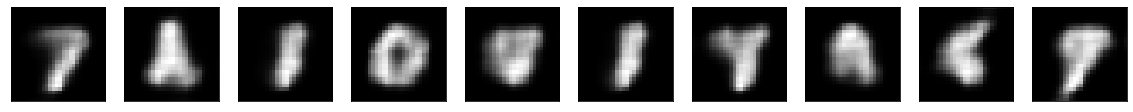

decoded images at epoch  150 :


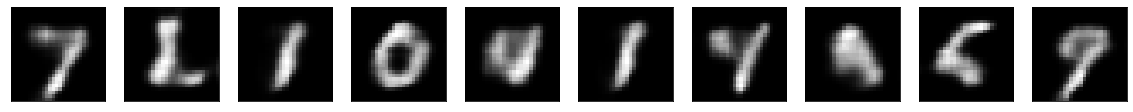

decoded images at epoch  200 :


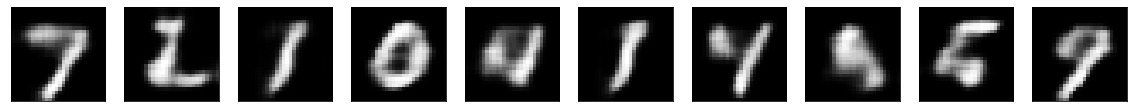

decoded images at epoch  250 :


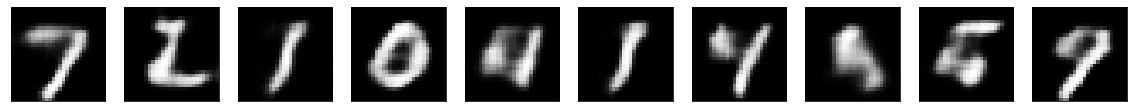

decoded images at epoch  300 :


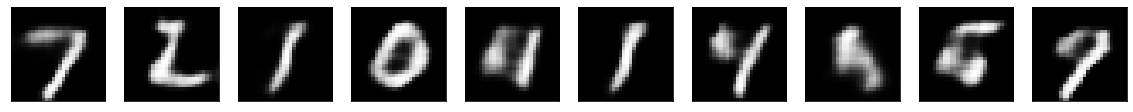

KeyboardInterrupt: 

In [23]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 2))
print_imgs(x_test[:10])
print_imgs(x_test_noisy[:10])
    
for i in range(10):
    autoencoder.fit(x_train_noisy[:1000], x_train[:1000],
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose = 0)
    
    # encode and decode some digits
    # note that we take them from the *test* set
    print('decoded images at epoch ', i*50 + 50, ':')
    decoded_imgs = autoencoder.predict(x_test[:10])
    print_imgs(decoded_imgs)

## 2.4. Autoencoder with CIFAR-10

### Exercise 4. 
Build your Autoencoder with CIFAR-10 and try to denoise CIFAR-10 images

In [31]:
from keras.datasets import cifar10

In [32]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format### Your code here

In [33]:
def print_imgs(X):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 2))
    for i in range(n):
        # display reconstruction
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(X[i].reshape(32, 32,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    plt.close()

In [35]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print_imgs(x_test[:10])
print_imgs(x_test_noisy[:10])

MemoryError: 

In [36]:
input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 
x = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

In [37]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)


decoded = Conv2D(3, (1, 1), activation='sigmoid')(x)

In [38]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 32)          0         
__________

<Figure size 1440x144 with 0 Axes>

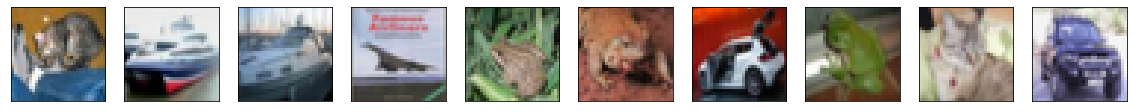

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

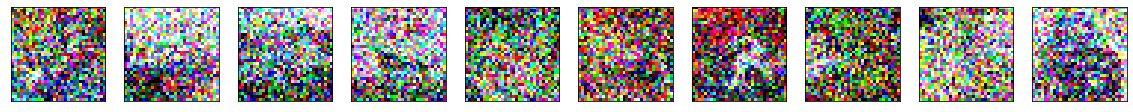

decoded images at epoch  5 :


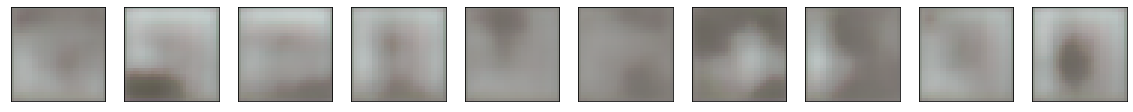

decoded images at epoch  10 :


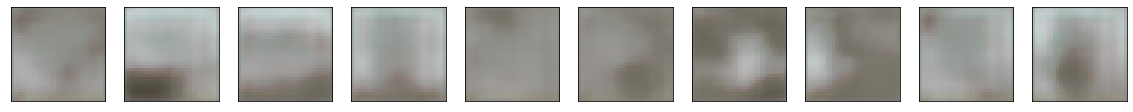

decoded images at epoch  15 :


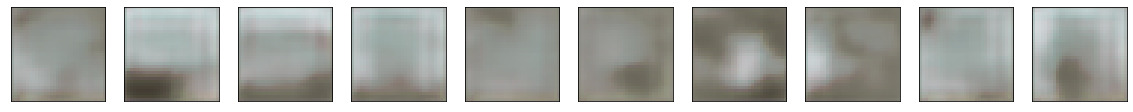

decoded images at epoch  20 :


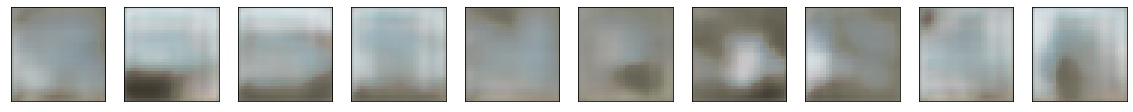

decoded images at epoch  25 :


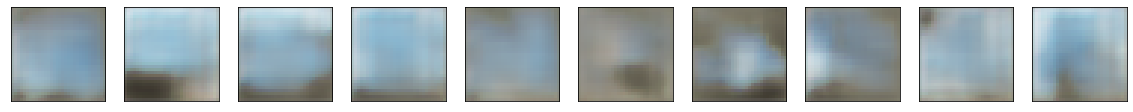

decoded images at epoch  30 :


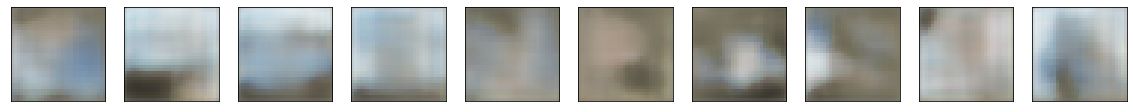

decoded images at epoch  35 :


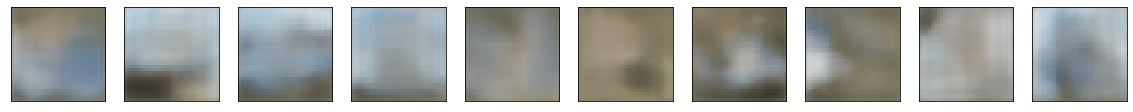

decoded images at epoch  40 :


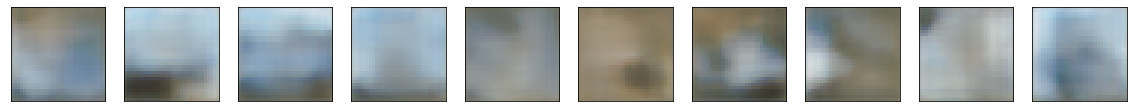

decoded images at epoch  45 :


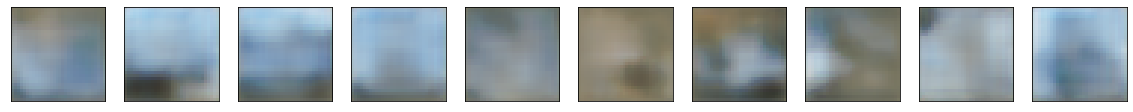

decoded images at epoch  50 :


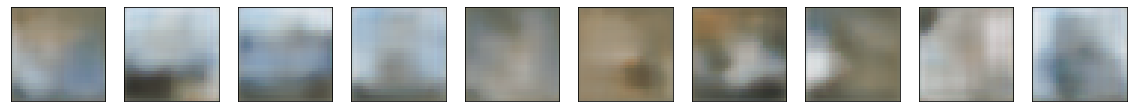

In [39]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 2))
print_imgs(x_test[:10])
print_imgs(x_test_noisy[:10])
    
for i in range(10):
    autoencoder.fit(x_train_noisy[:1000], x_train[:1000],
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose = 0)
    
    # encode and decode some digits
    # note that we take them from the *test* set
    print('decoded images at epoch ', i*5 + 5, ':')
    decoded_imgs = autoencoder.predict(x_test[:10])
    print_imgs(decoded_imgs)